<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_fault_network/blob/main/report_files/06_Boorara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural
      !pip install lavavu-osmesa==1.8.32 geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_seismic = r"./data/seismic"
path_shp = r"./data/gis"
path_DEM =  r"./data/DEM.tif"

In [4]:
# a function to darken the color of a hex list

def darken_color(color, amount=1.5):

    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [5]:
# import the oris and datas
updated_data = pd.read_csv("./data/LoopStructural_data/updated_data.csv")
updated_oris = pd.read_csv("./data/LoopStructural_data/updated_oris.csv")

In [6]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

# Add Boorara


In [7]:
Boorara_pts = gpd.read_file(os.path.join(path_shp, "Boorara_pts_elevation.shp"))
Boorara_pts = pd.DataFrame({'X': Boorara_pts.geometry.x, 
              'Y': Boorara_pts.geometry.y, 
              'Z': Boorara_pts.DEM_main})

Boorara_pts['fault_name'] = "Boorara Fault"

In [8]:
Boorara_seismic = gpd.read_file(os.path.join(path_seismic, "Boorara_fault.shp"))

Boorara_seismic = Boorara_seismic[['X', 'Y', 'depth_minu', 'FAULT']]
Boorara_seismic.columns = ['X', 'Y', 'Z', 'fault_name']

Boorara_seismic['fault_name'] = Boorara_seismic['fault_name'].str.replace('Boorara Shear Zone', "Boorara Fault")

In [9]:
gs = []

tmpA = []
tmpB = []

xs = Boorara_seismic['X'].to_numpy()
ys = Boorara_seismic['Y'].to_numpy()
zs = Boorara_seismic['Z'].to_numpy()

meanX = Boorara_pts['X'].mean()
meanY = Boorara_pts['Y'].mean()
meanZ = zs.mean() 

for j in range(len(xs)):
    tmpA.append([xs[j], ys[j], 1])
    tmpB.append(zs[j])

b = np.matrix(tmpB).T
A = np.matrix(tmpA)

fit = (A.T * A).I * A.T * b

# find the norms
kdr1 = pd.DataFrame({'gx': [fit[0,0]], 
                  'gy': fit[1,0], 
                  'gz': -1})

kdr1 /= np.linalg.norm(kdr1)

gs.append(['Boorara Fault', meanX, meanY, meanZ, 
           kdr1['gx'][0], 
           kdr1['gy'][0],
           kdr1['gz'][0]])

In [10]:
ori = pd.DataFrame(gs, columns = ['fault_name', 'X', 'Y', 'Z', 'gx', 'gy', 'gz'])
updated_ori = pd.concat([updated_oris, ori])

In [11]:
updated_data = pd.concat([updated_data, Boorara_seismic, Boorara_pts])

In [12]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [13]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                             origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)

model.data = processor.data

model.nsteps = [200, 200, 500]

model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 3                     geological features that need to be interpolated



  0%|          | 0/3 [00:00<?, ?it/s]

Model update took: 10.005096673965454 seconds


Object exists: x



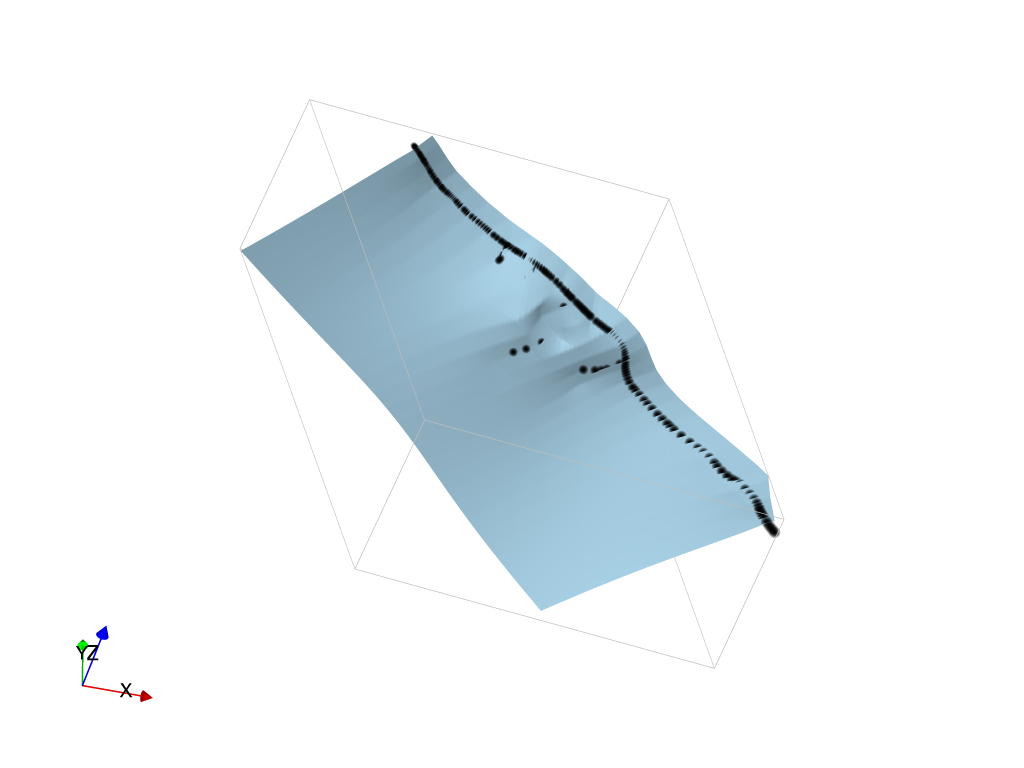

In [14]:
view = LavaVuModelViewer(model)

view.add_isosurface(model['Boorara Fault'], colours = ['#a6cee3'], value = 0)

# view.add_data(model['Boorara Fault'][0])
view.add_points(Boorara_seismic[['X', 'Y', 'Z']], pointsize = 10, name = 'x')
view.add_points(Boorara_pts[['X', 'Y', 'Z']], pointsize = 5, pointcolour = 'green', name = 'x')

view.rotation = [-63.87424850463867, 20.224990844726562, -15.441508293151855]
view.display()

# view.interactive()

# Add to main model

In [15]:
updated_ori = pd.concat([updated_oris, ori])
updated_data = pd.concat([updated_data, Boorara_seismic, Boorara_pts])

In [18]:
processor = ProcessInputData(fault_locations = updated_data, fault_orientations = updated_ori,
                             origin=origin, maximum=maximum)

model = GeologicalModel(origin, maximum)
model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 
model.data = processor.data
# model.nsteps = [100, 100, 250]

##########################################
####### Faults from previous work ########
##########################################
model.create_and_add_fault('Ida Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw=5, cpw = 0.05)

model.create_and_add_fault('Kunanalling Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                          npw = 5, cpw = 0.05)

model.create_and_add_fault('Bulla_Abut_South', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bulla_Abut_North', displacement = 5, nelements=1e4)
model.create_and_add_fault('Bullabulling South Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Bullabulling North Fault', displacement = 5, nelements=1e4, cpw = 0.2)
model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('MtMonger Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, cwp = 0.2)
model.create_and_add_fault('Kanowna Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, npw = 0.5, cpw = 0.2)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])

# Force the tangents on Bullabulling Fault
tang2 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling North Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling North Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling North Fault'][0].interpolator.support.barycentre,
                vector = tang2, w=1, B=0)

tang3 = np.tile([-30838.81,  -3624.64,  12250.14],
                (model['Bullabulling South Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Bullabulling South Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Bullabulling South Fault'][0].interpolator.support.barycentre,
                vector = tang3, w=1, B=0)

# add abutting relationships
model['Kunanalling Fault'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Bulla_Abut_North'])
model['Bullabulling South Fault'].add_abutting_fault(model['Bulla_Abut_South'])
model['Bulla_Abut_South'].add_abutting_fault(model['Ida Fault'])
model['Bullabulling North Fault'].add_abutting_fault(model['Kunanalling Fault'])
model['Bulla_Abut_North'].add_abutting_fault(model['Ida Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Kunanalling Fault'])
model['Kanowna Fault'].add_abutting_fault(model['MtMonger Fault'])

model.update(verbose = True)

C:\Users\angel\anaconda3\envs\loop2\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


Updating geological model. There are: 
 30                     geological features that need to be interpolated



  0%|          | 0/30 [00:00<?, ?it/s]

Model update took: 112.80391955375671 seconds



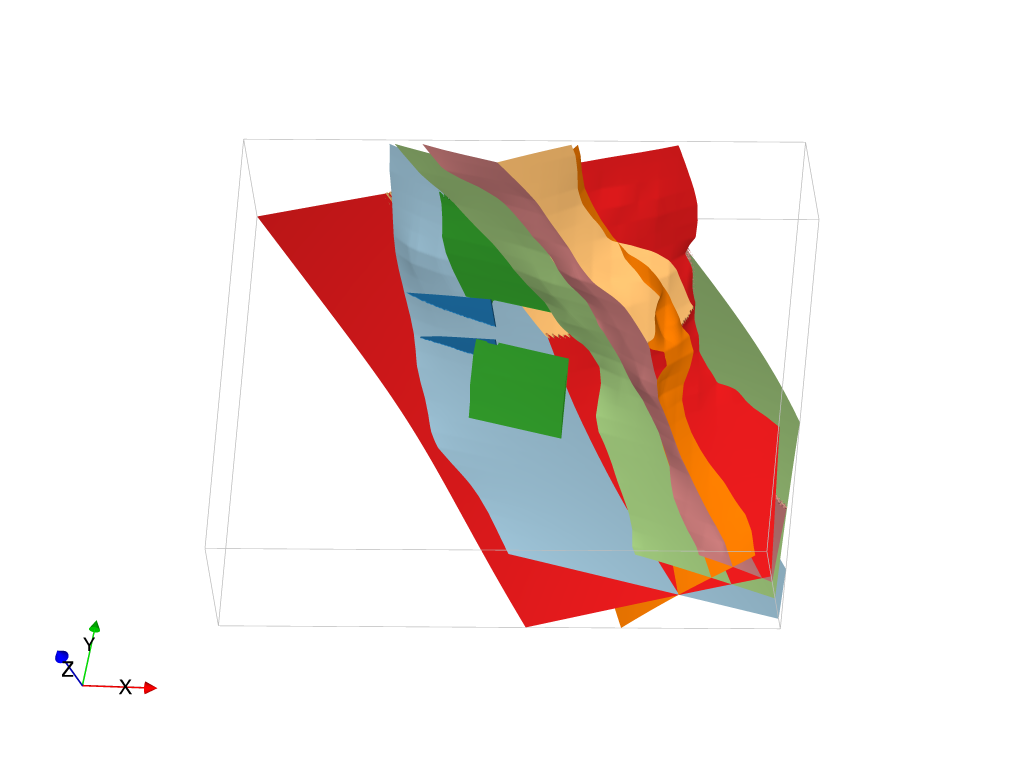

In [19]:
view = LavaVuModelViewer(model)

color_list = ['#a6cee3', '#b2df8a', '#1f78b4', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00']

view.nelements = 1e7

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)

view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)

view.zmax = 0.95
# view.interactive()

view.rotation = [-35.16962432861328, -7.262160778045654, -0.3087376356124878]
view.display()

# Adding abutting relationships

In [20]:
# 1. Boorara ends at Kanowna - seismic Line 2; composite view, line 3

model['Boorara Fault'].add_abutting_fault(model['Kanowna Fault'])
model['Boorara Fault'].add_abutting_fault(model['MtMonger Fault'])

Object exists: Ida Fault_value_cp
Object exists: Ida Fault_value_cp
Object exists: Kunanalling Fault_value_cp
Object exists: Kunanalling Fault_value_cp
Object exists: Bulla_Abut_South_value_cp
Object exists: Bulla_Abut_South_value_cp
Object exists: Bullabulling South Fault_value_cp
Object exists: Bullabulling South Fault_value_cp
Object exists: Zuleika Fault_value_cp
Object exists: Zuleika Fault_value_cp



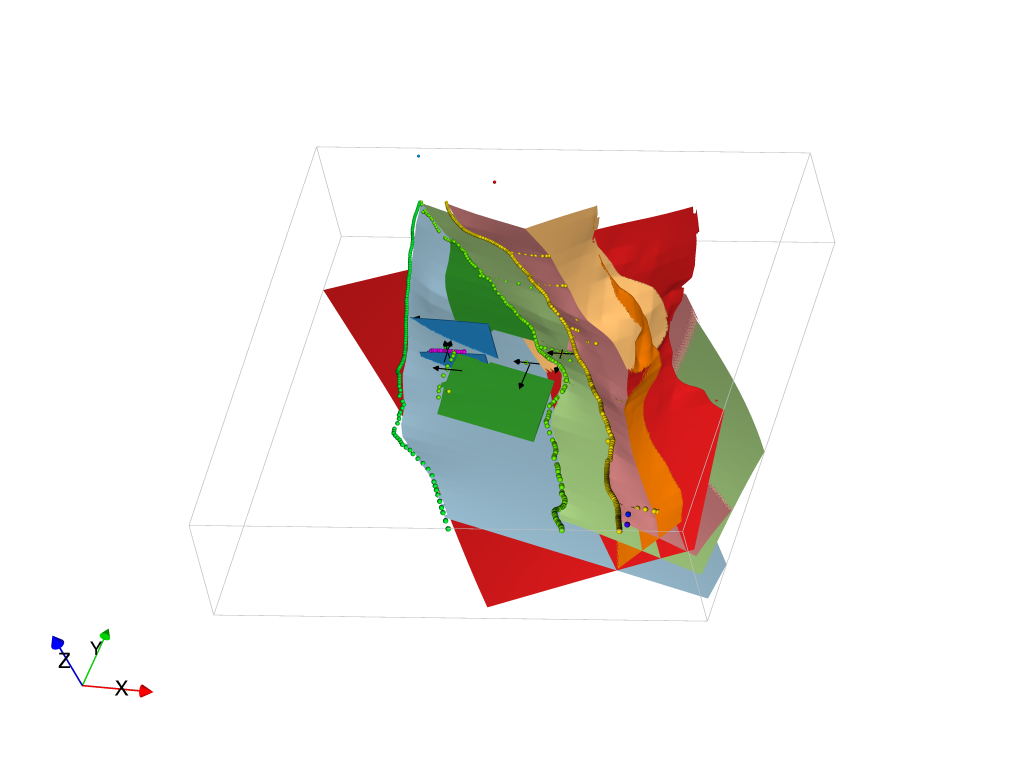

In [21]:
view = LavaVuModelViewer(model)

color_list = ['#a6cee3', '#b2df8a', '#1f78b4', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00']

view.nelements = 1e7

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_data(model['Ida Fault'], vectors=True)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)
view.add_data(model['Kunanalling Fault'], vectors=True)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_data(model['Bulla_Abut_South'], vectors=True)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_data(model['Bullabulling South Fault'], vectors=True)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_data(model['Zuleika Fault'], vectors=True)
view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)

view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)

# for fault_n in updated_ori['fault_name']:
#     view.add_data(model[fault_n][0])

# pts_files = [Ida_pts, Kunanalling_pts, Bull_N_pts, Bull_S_pts, Zuleika_pts, MtMonger_pts[['X', 'Y', 'Z']], 
#              Kanowna_pts[['X', 'Y', 'Z']], Boorara_pts[['X', 'Y', 'Z']]]
# pts_names = ['Ida_pts', 'Kunanalling_pts', 'Bull_N_pts', 'Bull_S_pts', 'Zuleika_pts', 'MtMonger_pts', 'Kanowna points',
#             'Boorara_pts']

# for j, p in enumerate(pts_files):
#     view.add_points(p, name = pts_names[j], pointsize = 5, colour = darken_color(color_list[j]))

# view.add_points(Boorara_seismic[['X', 'Y', 'Z']], name = "Kanowna seismic", pointsize = 10, colour = "black")

# view.zmax = 0.95
# view.interactive()

view.rotation = [-46.578861236572266, -17.81783676147461, -0.7082947492599487]
view.display()

# save new datafiles

In [22]:
updated_data.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_data.csv", index=False)
updated_ori.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_oris.csv", index=False)

# How does Boulder-Lefroy sit in all of this?

In [23]:
BL = gpd.read_file(os.path.join(path_shp, "Boulder_Lefroy_original.shp"))


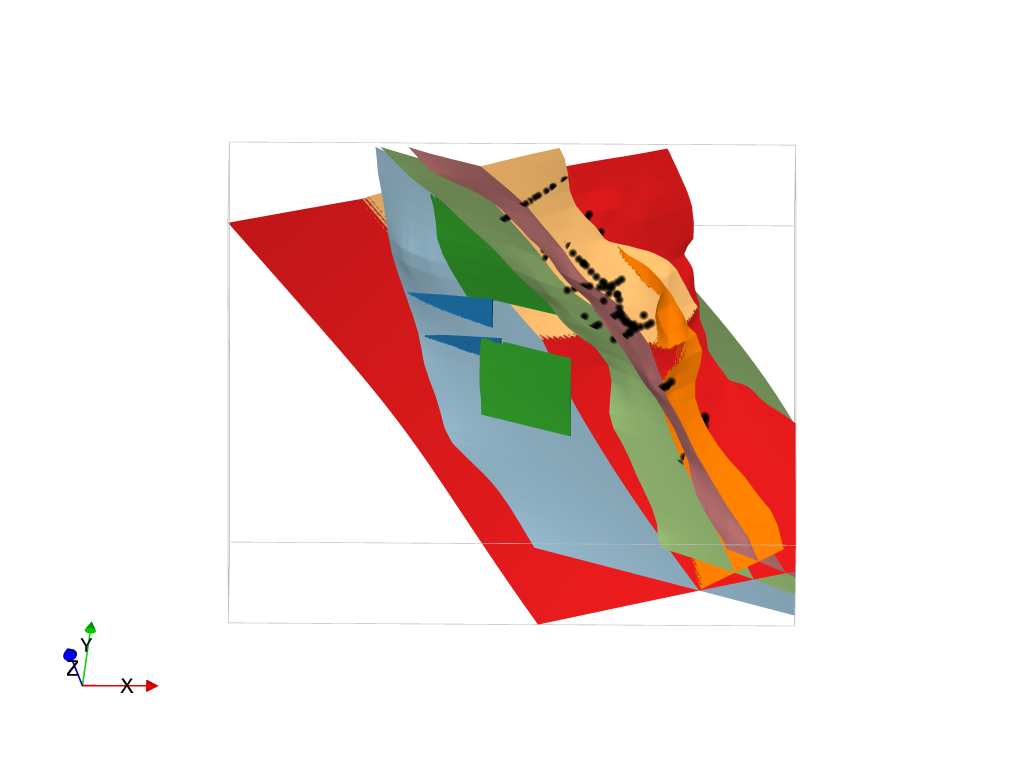

In [26]:
view = LavaVuModelViewer(model)

color_list = ['#a6cee3', '#b2df8a', '#1f78b4', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00']

view.nelements = 1e7

view.add_isosurface(model['Ida Fault'], colours = ['#a6cee3'], value = 0)
view.add_isosurface(model['Kunanalling Fault'], colours = ['#b2df8a'], value = 0)

view.add_isosurface(model['Bulla_Abut_South'], colours = ['#1f78b4'], value = 0)
view.add_isosurface(model['Bulla_Abut_North'], colours = ['#1f78b4'], value = 0)

view.add_isosurface(model['Bullabulling South Fault'], colours = ['#33a02c'], value = 0)
view.add_isosurface(model['Bullabulling North Fault'], colours = ['#33a02c'], value = 0)

view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
view.add_isosurface(model['MtMonger Fault'], colours = ['#e31a1c'], value = 0)

view.add_isosurface(model['Kanowna Fault'], colours = ['#fdbf6f'], value = 0)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0, vectors=True)

    
view.add_points(BL[['X', 'Y', 'depth_minu']], name = "X", pointsize = 10, colour = "black")

view.zmax = 0.95
# view.interactive()

view.rotation = [-37.00056838989258, 0.49606192111968994, -0.32233819365501404]
view.display()

In [25]:
updated_data.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_data.csv", index=False)
updated_ori.reset_index(drop=True).to_csv("./data/LoopStructural_data/updated_oris.csv", index=False)